# Coupled Oscillators

Code for drawing a spring in matplotlib was provided in the blog post [The spring pendulum](https://scipython.com/blog/the-spring-pendulum/).

Uncomment and run the cell below if you need to install the `mplEasyAnimate` package. [mplEasyAnimate](https://github.com/tboudreaux/mpl_animate) package was created by HPU alumnus Thomas Boudreaux.

In [ ]:
#!pip install mplEasyAnimate

Import packages.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# calculate eigenvalues and eigenvectors
from scipy.linalg import eigh

# print to markdown
from IPython.display import display, Markdown, Latex

# draw circles on a graph
from matplotlib.patches import Circle

## the packages below are used to create an animation as a mp4 file and display it in the notebook
from IPython.display import HTML
from mplEasyAnimate import animation
from tqdm import tqdm
from base64 import b64encode

Functions to shorten the code.

In [4]:
def normal_modes(Natoms, ks, mass):

    #Build matrices
    A=np.zeros((Natoms,Natoms))

    for i in range(Natoms):
        A[i,i] = 2*ks
        if i==0:
            A[0,i+1]=-ks
        elif i==Natoms-1:
            A[i,i-1]=-ks
        else:
            A[i,i-1]=-ks
            A[i,i+1]=-ks

    B=mass*np.identity(Natoms)

    #find eigenvalues and eigenvectors
    lamb, a = eigh(A, B)        # eigenvalues and eigenvectors
    #print("eigenvalues (omega^2):", lamb)
    #print("eigenvectors are column vectors in:\n\n", a)
    omegas = np.sqrt(lamb)

    return omegas, a

def superposition(Natoms, ks, mass, ui, t_total):

    #Build matrices
    A=np.zeros((Natoms,Natoms))

    for i in range(Natoms):
        A[i,i] = 2*ks
        if i==0:
            A[0,i+1]=-ks
        elif i==Natoms-1:
            A[i,i-1]=-ks
        else:
            A[i,i-1]=-ks
            A[i,i+1]=-ks

    B=mass*np.identity(Natoms)

    #find eigenvalues and eigenvectors
    lamb, a = eigh(A, B)        # eigenvalues and eigenvectors

    #Find coefficients for normal modes
    Acoeffs = np.linalg.solve(a,ui)

    #build the general solution
    t = np.linspace(0,t_total,1000)

    omegas = np.sqrt(lamb)
    data = np.zeros((len(t),Natoms+1))
    data[:,0] = t #store time in first column, u_i in other columns

    for i in range(Natoms):
        for w in range(0,len(omegas)):
            data[:,i+1] = data[:,i+1] + Acoeffs[w]*a[i,w]*np.cos(omegas[w]*t)

    return data, Acoeffs

def plot_spring(ax, x, y, theta, L):
    """Plot the spring from (0,0) to (x,y) as the projection of a helix."""
    # Code for drawing a spring in matplotlib was provided in the blog post: 
    #     [The spring pendulum](https://scipython.com/blog/the-spring-pendulum/)

    # Spring turn radius, number of turns
    rs, ns = 0.1, 25
    # Number of data points for the helix
    Ns = 1000
    # We don't draw coils all the way to the end of the pendulum:
    # pad a bit from the anchor and from the bob by these number of points
    ipad1, ipad2 = 100, 150
    w = np.linspace(0, L, Ns)
    # Set up the helix along the x-axis ...
    xp = np.zeros(Ns)
    xp[ipad1:-ipad2] = rs * np.sin(2*np.pi * ns * w[ipad1:-ipad2] / L)
    # ... then rotate it to align with  the pendulum and plot.
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    xs, ys = - R @ np.vstack((xp, w))
    ax.plot(x+xs, y+ys, c='k', lw=2)

def animate_matplotlib(filename, N, L0, data, skip=10):

    r = 0.1

    x0 = -(N+1)*L0/2
    y0 = 0

    springs = []
    xeq = np.linspace(x0+L0, x0+N*L0, N)

    Niterations = len(data[:,0])

    with animation(filename, fps=30) as anim:
        t_offsets = np.arange(Niterations)
        i=0
        for offset in tqdm(t_offsets):

            if i>0 and i % (skip-1) == 0:
                fig = plt.figure(figsize=(12, 6), dpi=72)
                ax = fig.add_subplot(111)

                c0 = Circle((x0, y0), r/2, fc='k', zorder=10) #left end
                ax.add_patch(c0)

                L = L0 + data[i,1]
                plot_spring(ax, x0, y0, np.pi/2, L)

                for n in range(N):
                    u = data[i,n+1]
                    x = xeq[n] + u
                    c = Circle((x, 0), r, fc='r', ec='r', zorder=10)
                    ax.add_patch(c)
                    if n>0:
                        xprev = xeq[n-1] + data[i,n]
                        L = x - xprev
                        plot_spring(ax, xprev, y0, np.pi/2, L)

                xend = x0+(N+1)*L0
                xlast = xeq[-1]+data[i,-1]
                L = xend-xlast
                plot_spring(ax, xlast, y0, np.pi/2, L)
                cN = Circle((xend, y0), r/2, fc='k', zorder=10) #right end
                ax.add_patch(cN)

                ax.set_xlim(-1.1*(N+1)*L0/2, 1.1*(N+1)*L0/2)
                ax.set_ylim(-L0/4, L0/4)
                ax.set_aspect('equal', adjustable='box')
                plt.axis('off')

                anim.add_frame(fig)
                plt.close(fig)
            i=i+1


Global variables.

In [5]:
# Global Variables
L = 10 # length of the system
M = 2 # mass of the system
K = 1 # stiffness of the system

## One Mass

Start with a single oscillator of a mass on a spring. Its motion is described by

$$u = a\cos(\omega t + \phi)$$

where $u$ is its displacement from equilibrium, $a$ is the amplitude, $\omega$ is the angular frequency and $\phi$ is the phase. You can adjust the object's initial position and velocity to see how it affects amplitude and phase.

In [9]:
u1i=-2 #initial displacement from equilibrium
u1doti=0 #initial velocity

##########

N = 1 #number of atoms (or balls)
L0 = L/2 #length of a spring
k=2*K #stiffness
m=M #mass

# calculate u(t)
t_total = 10
omega = np.sqrt(2*k/m)
ta = np.linspace(0,t_total,1000)
phi = np.arctan2(-u1doti, omega*u1i)
a = u1i/np.cos(phi)
u1a = a*np.cos(omega*ta + phi)

data = np.column_stack((ta,u1a))

#create animation
filename = 'one-mass.mp4'
animate_matplotlib(filename, N, L0, data)

#display animation
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

100%|██████████| 1000/1000 [00:32<00:00, 30.99it/s]


Plot the displacement of the mass $u$ (from equilibrium) as a function of time $t$. Note how this depicts the same information as the animation, but it's not dynamic and it's not a "picture" of the motion.

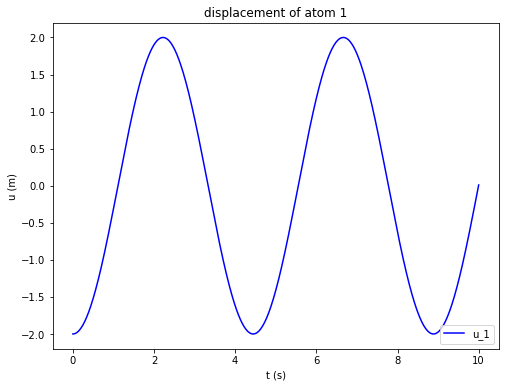

In [10]:
plt.figure(figsize=(8,6))
plt.title("displacement of atom 1")
plt.plot(data[:,0],data[:,1], 'b-', label='u_1')
plt.xlabel('t (s)')
plt.ylabel('u (m)')
plt.legend(loc='lower right')
plt.show()

## Two Masses

For one mass, there is only one mode of oscillation. For two masses, there are two *modes* of oscillations. First, we calculate the frequency of each of the modes and the corresponding *eigenvector* for each frequency.

In [11]:
N = 2 #number of atoms (or balls)
L0 = L/(N+1) #length of a spring
k=(N+1)*K #stiffness
m=M/N #mass

eig_freq, eig_vec = normal_modes(N, k, m)

table = "The eigenvalues are $\lambda = \omega^2$."
table= table + "\n\n| mode | $\omega$ (rad/s) | eigenvector (m) |"
table = table + "\n| :-: | :-: | :-:|"

for i in range(len(eig_freq)):
    table=table+"\n|"+ "{:d} | {:.4f} | [{:.4f}, {:.4f}] |".format(i, eig_freq[i], *eig_vec[:,i])
    
display(Markdown(table))

summary = "\nThe eigenvectors are column vectors for the matrix $\\vec{a}$:"

matrix = '''\n
$$ \\vec{a} =
\left[ {\\begin{array}{cc}
   %.4f & %.4f \\\\
   %.4f & %.4f \\\\
  \end{array} } \\right]
$$
''' %(eig_vec[0,0], eig_vec[0,1], eig_vec[1,0], eig_vec[1,1])

summary = summary + matrix

summary = summary + '\n\n The combination of an eigenvalue and its eigenvector are called the *normal modes*.'

display(Markdown(summary))

The eigenvalues are $\lambda = \omega^2$.

| mode | $\omega$ (rad/s) | eigenvector (m) |
| :-: | :-: | :-:|
|0 | 1.7321 | [-0.7071, -0.7071] |
|1 | 3.0000 | [-0.7071, 0.7071] |


The eigenvectors are column vectors for the matrix $\vec{a}$:

$$ \vec{a} =
\left[ {\begin{array}{cc}
   -0.7071 & -0.7071 \\
   -0.7071 & 0.7071 \\
  \end{array} } \right]
$$


 The combination of an eigenvalue and its eigenvector are called the *normal modes*.

### Normal Modes

For a given mode, both masses oscillate with the same frequency (corresponding to the eigenvalue for this mode). The eigenvector tells us the amplitude of each mass.

The equation of motion of each particle ($u_1(t)$ and $u_2(t)$) for mode 0 is:

$$
\left[ {\begin{array}{c}
    u_1 \\
    u_2 \\
  \end{array} } \right]
  = 
\left[ {\begin{array}{c}
    a_{00} \\
    a_{10} \\
  \end{array} } \right]
  \cos(\omega_0t)
$$

In [12]:
t_total = 10*np.pi
mode=0

###########
t = np.linspace(0,t_total,1000)

omega = np.sqrt(eig_freq[mode])
data = np.zeros((len(t),N+1))
data[:,0] = t #store time in first column, u_i in other columns

for i in range(N):
    data[:,i+1] = eig_vec[i,mode]*np.cos(omega*t)

#create animation
filename = 'two-masses-mode-0.mp4'
animate_matplotlib(filename, N, L0, data)

#display animation
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

100%|██████████| 1000/1000 [00:32<00:00, 30.81it/s]


The equation of motion of each particle for mode 1 is:

$$
\left[ {\begin{array}{c}
    u_1 \\
    u_2 \\
  \end{array} } \right]
  = 
\left[ {\begin{array}{c}
    a_{01} \\
    a_{11} \\
  \end{array} } \right]
  \cos(\omega_1t)
$$

In [13]:
t_total = 10*np.pi
mode=1

###########
t = np.linspace(0,t_total,1000)

omega = np.sqrt(eig_freq[mode])
data = np.zeros((len(t),N+1))
data[:,0] = t #store time in first column, u_i in other columns

for i in range(N):
    data[:,i+1] = eig_vec[i,mode]*np.cos(omega*t)

#create animation
filename = 'two-masses-mode-1.mp4'
animate_matplotlib(filename, N, L0, data)

#display animation
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

100%|██████████| 1000/1000 [00:31<00:00, 31.61it/s]


We will use this to describe the motion of the system with any initial position and velocity of the two masses. You can write the position of each mass as a sum of the normal modes.

$$
\left[ {\begin{array}{c}
    u_1 \\
    u_2 \\
  \end{array} } \right]
  = A_0
\left[ {\begin{array}{c}
    a_{00} \\
    a_{10} \\
  \end{array} } \right]
  \cos(\omega_0t + \phi_0)
+ A_1
\left[ {\begin{array}{c}
    a_{01} \\
    a_{11} \\
  \end{array} } \right]
  \cos(\omega_1t + \phi_1)
$$

The coefficients $A_0$ and $A_1$ and phases $\phi_0$ and $\phi_1$ depend on the position and velocity of each mass at $t=0$. Let's assume the initial velocity of both masses is zero. Then $A_0$ and $A_1$ only depend on the initial displacements of the masses.

Play with the initial displacements $u_{1i}$ and $u_{2i}$ below and view the motion of the system.

In [14]:
u_1i = -0.4
u_2i = 0

#################
ui = np.array([u_1i,u_2i])

t_total = 15*np.pi

data, coeffs = superposition(N, k, m, ui, t_total)

#print("A coefficients = ", coeffs)

#create animation
filename = 'superposition-two-masses.mp4'
skip = 5 #render every 5th frame in animation
animate_matplotlib(filename, N, L0, data, skip)

#display animation
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

100%|██████████| 1000/1000 [01:11<00:00, 14.03it/s]


Plot $u(t)$ for each mass. It's difficult to imagine the oscillations by viewing the graph alone.

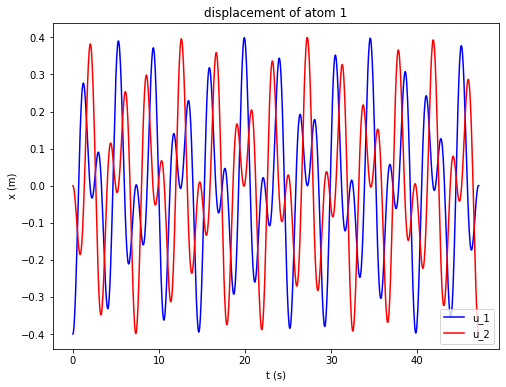

In [11]:
plt.figure(figsize=(8,6))
plt.title("displacement of atom 1")
plt.plot(data[:,0],data[:,1], 'b-', label='u_1')
plt.plot(data[:,0],data[:,2], 'r-', label='u_2')
plt.xlabel('t (s)')
plt.ylabel('x (m)')
plt.legend(loc='lower right')
plt.show()


## Three Masses

Find the frequencies and eigenvectors for the normal modes.

In [15]:
N = 3 #number of atoms (or balls)
L0 = L/(N+1) #length of a spring
k=(N+1)*K #stiffness
m=M/N #mass

eig_freq, eig_vec = normal_modes(N, k, m)


table="| mode | $\omega$ (rad/s) | eigenvector (m) |"
table = table + "\n| :-: | :-: | :-:|"

for i in range(len(eig_freq)):
#    table=table+"\n|"+ "{:d} | {:.4f} | [{:.4f}, {:.4f}, {:.4f} ] |".format(i, eig_freq[i], eig_vec[0,i], eig_vec[1,i], eig_vec[2,i])
    table=table+"\n|"+ "{:d} | {:.4f} | [{:.4f}, {:.4f}, {:.4f} ] |".format(i, eig_freq[i], *eig_vec[:,i])

display(Markdown(table))

| mode | $\omega$ (rad/s) | eigenvector (m) |
| :-: | :-: | :-:|
|0 | 1.8748 | [0.6124, 0.8660, 0.6124 ] |
|1 | 3.4641 | [-0.8660, -0.0000, 0.8660 ] |
|2 | 4.5261 | [-0.6124, 0.8660, -0.6124 ] |

In [13]:
t_total = 10*np.pi
mode=0

###########
t = np.linspace(0,t_total,1000)

omega = np.sqrt(eig_freq[mode])
data = np.zeros((len(t),N+1))
data[:,0] = t #store time in first column, u_i in other columns

for i in range(N):
    data[:,i+1] = eig_vec[i,mode]*np.cos(omega*t)

#create animation
filename = 'three-masses-mode-0.mp4'
animate_matplotlib(filename, N, L0, data, skip=5)

#display animation
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

100%|██████████| 1000/1000 [01:12<00:00, 13.76it/s]


In [14]:
t_total = 10*np.pi
mode = 1

###########
t = np.linspace(0,t_total,1000)

omega = np.sqrt(eig_freq[mode])
data = np.zeros((len(t),N+1))
data[:,0] = t #store time in first column, u_i in other columns

for i in range(N):
    data[:,i+1] = eig_vec[i,mode]*np.cos(omega*t)

#create animation
filename = 'three-masses-mode-1.mp4'
animate_matplotlib(filename, N, L0, data, skip=5)

#display animation
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

100%|██████████| 1000/1000 [01:12<00:00, 13.83it/s]


In [15]:
t_total = 10*np.pi
mode=2

###########
t = np.linspace(0,t_total,1000)

omega = np.sqrt(eig_freq[mode])
data = np.zeros((len(t),N+1))
data[:,0] = t #store time in first column, u_i in other columns

for i in range(N):
    data[:,i+1] = eig_vec[i,mode]*np.cos(omega*t)

#create animation
filename = 'three-masses-mode-2.mp4'
animate_matplotlib(filename, N, L0, data, skip=5)

#display animation
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

100%|██████████| 1000/1000 [01:12<00:00, 13.81it/s]


The general solution is the superposition of modes.

$$
\left[ {\begin{array}{c}
    u_1 \\
    u_2 \\
    u_3 \\
  \end{array} } \right]
  = A_0
\left[ {\begin{array}{c}
    a_{00} \\
    a_{10} \\
    a_{20} \\
  \end{array} } \right]
  \cos(\omega_0t + \phi_0)
+ A_1
\left[ {\begin{array}{c}
    a_{01} \\
    a_{11} \\
    a_{21} \\
  \end{array} } \right]
  \cos(\omega_1t + \phi_1)
+ A_2
\left[ {\begin{array}{c}
    a_{02} \\
    a_{12} \\
    a_{22} \\
  \end{array} } \right]
  \cos(\omega_2t + \phi_2)
$$


In [ ]:
u_1i = -0.4
u_2i = 0
u_3i = 0

#################
ui = np.array([u_1i,u_2i,u_3i])

t_total = 10*np.pi

data, coeffs = superposition(N, k, m, ui, t_total)

#print("A coefficients = ", coeffs)

#create animation
filename = 'superposition-three-masses.mp4'
skip = 5 #render every 5th frame in animation
animate_matplotlib(filename, N, L0, data, skip)

#display animation
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Exercises

### Exercise 1

1. Get a group of three people and act out the different modes of oscillation for a system of three masses. 
2. Record a video.


### Exercise 2

Model the motion of a chain of five masses.

1. print the frequency and eigenvector for each mode.
2. animate each mode.
3. plot $u_i(t)$ for each mass and describe the masses that oscillate with the same phase.
4. calculate and plot the motion of the system given the initial displacement of each mass.
5. get a group of five people and act out the different modes of oscillation for a system of five masses.